In [1]:
# Interactive Figure
%matplotlib ipympl 
# Non interactive
# %matplotlib inline 

In [2]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qm import SimulationConfig
from qualang_tools.results import fetching_tool
from qualang_tools.loops import from_array
import config_00 as config
import warnings
warnings.filterwarnings("ignore")
msg=np.load("msg_1007.npz")
msgI=msg["x"]
msgQ=msg["y"]

2025-05-21 18:02:27,159 - qm - INFO     - Starting session: 46331fd0-6a93-4a0e-9934-0f06b1f02d65


In [3]:
def addjob(qmprog, qm):
    # Add a QUA program to the OPX queue, which compiles it and executes it
    job = qm.queue.add(qmprog)
    # Wait for job to be loaded
    while job.status=="loading":
        print("Job is loading...")
        time.sleep(0.1)
    # Wait until job is running
    time.sleep(0.1)
    while job.status=="pending":
        q = job.position_in_queue()
        if q>0:
            print("Position in queue",q,end='\r')
        time.sleep(0.1)
    job=job.wait_for_execution()
    print("\nJob is running")
    return job

In [4]:
import threading
from IPython.display import display
import ipywidgets as widgets

class ProgressPlot:
    def __init__(self, job, timelimit=20):
        self.progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
        self.button = widgets.Button(description='Abort',)
        self.button.on_click(self.stop)
        self.keeprunning = True
        self.timelimit = timelimit
        self.job = job
        with plt.ioff():
            self.fig = plt.figure()
        self.initplot()
        self.start_time = time.time()
        self.thread = threading.Thread(target=self.update,)
        self.thread.start()
    def stop(self,b):
        self.keeprunning = False
    def initplot(self):
        pass
    def replot(self):
        pass
    def update(self):
        dt = 0
        while dt<1 and self.keeprunning and job.status=='running':
            dt = (time.time()-self.start_time)/self.timelimit
            self.progress.value = dt
            self.replot()
            self.fig.canvas.draw_idle()
            time.sleep(0.1)
        self.job.halt()
        print('Job finished')
    def show(self):
        display(self.fig.canvas,widgets.HBox([self.button,self.progress]))

In [5]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-05-21 18:02:31,500 - qm - INFO     - Performing health check
2025-05-21 18:02:31,507 - qm - INFO     - Health check passed


# Connexion à la Quantum Machine

In [6]:
# Get the QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1690924225045


# Send Pulses and Demodulate them

In [7]:
n_points = len(msgI)*2
with program() as prog:
    i = declare(int)
    n = declare(int)
    m = declare(int)
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature
    Im = declare(fixed,value=msgI)
    Qm = declare(fixed,value=msgQ)    
   
    with infinite_loop_():
        with for_(m, 0, m < len(msgI), m + 1):  
            play("pulse" * amp(Im[m],0.,Qm[m],0.),"qubit",duration=2*800*u.ns)

    with infinite_loop_():
        # Demodulate the signals to get the 'I' & 'Q' quadratures)
        measure(
            "readout",
            "scope",
            dual_demod.full("cos", "sin", I),
            dual_demod.full("minus_sin", "cos", Q),
        )
        # Save the 'I' & 'Q' quadratures to their respective streams
        save(I, I_st)
        save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, and store the results on the OPX processor
        I_st.buffer(n_points).save("I")
        Q_st.buffer(n_points).save("Q")


In [8]:
class myProgressPlot(ProgressPlot):
    mag = 20
    def initplot(self):
        self.ax = self.fig.subplots()
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-1,1)
        self.ax.set_ylim(-1,1)
        self.line, = self.ax.plot(np.zeros(n_points),np.zeros(n_points),',')
    def replot(self):
        I,Q = res.fetch_all()
        self.line.set_data(I*self.mag,Q*self.mag)

2025-05-21 18:03:07,547 - qm - INFO     - Sending program to QOP for compilation

Job is running


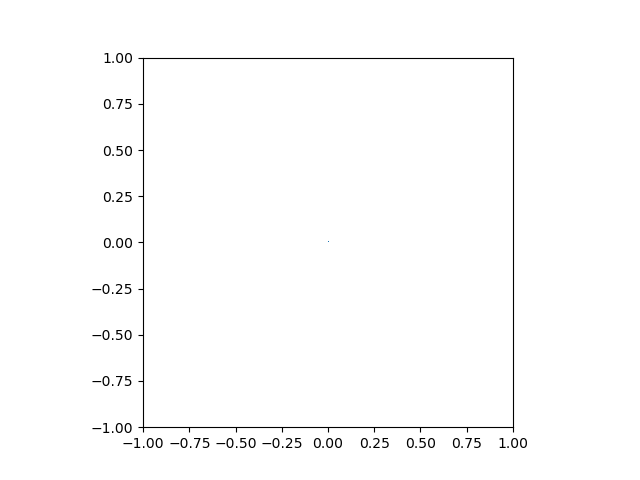

Job finished


In [10]:
# Run the code and fetch results
job = addjob(prog, qm)
res = fetching_tool(job, ['I','Q'],mode='live')
pp = myProgressPlot(job)
pp.show()

In [ ]:
pp.mag=20

# Pour ceux qui aiment coder

- Ajouter un curseur pour faire tourner le message en temps réel
- Ajouter un curseur pour effectuer un zoom avant et arrière sur le graphique
([lien vers la doc](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html))